# import

In [1]:
import numpy as np
from scipy import stats #高度な科学技術計算を行うためのモジュール
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt 
from IPython.display import display, HTML # 画像表示などを行うためのモジュール
%matplotlib inline

# X-meansを行うクラスの定義

In [2]:
class XMeans:
    """
    x-means法を行うクラス
    """

    def __init__(self, k_init = 2, **k_means_args):
        """
        k_init : The initial number of clusters applied to KMeans()
        """
        self.k_init = k_init
        self.k_means_args = k_means_args

    def fit(self, X):
        """
        x-means法を使ってデータXをクラスタリングする
        X : array-like or sparse matrix, shape=(n_samples, n_features)
        """
        self.__clusters = [] 

        clusters = self.Cluster.build(X, KMeans(self.k_init, **self.k_means_args).fit(X))
        self.__recursively_split(clusters)

        self.labels_ = np.empty(X.shape[0], dtype = np.intp)
        for i, c in enumerate(self.__clusters):
            self.labels_[c.index] = i

        self.cluster_centers_ = np.array([c.center for c in self.__clusters])
        self.cluster_log_likelihoods_ = np.array([c.log_likelihood() for c in self.__clusters])
        self.cluster_sizes_ = np.array([c.size for c in self.__clusters])

        return self

    def __recursively_split(self, clusters):
        """
        引数のclustersを再帰的に分割する
        clusters : list-like object, which contains instances of 'XMeans.Cluster'
        'XMeans.Cluster'のインスタンスを含むリスト型オブジェクト
        """
        for cluster in clusters:
            if cluster.size <= 3:
                self.__clusters.append(cluster)
                continue

            k_means = KMeans(2, **self.k_means_args).fit(cluster.data)
            c1, c2 = self.Cluster.build(cluster.data, k_means, cluster.index)

            beta = np.linalg.norm(c1.center - c2.center) / np.sqrt(np.linalg.det(c1.cov) + np.linalg.det(c2.cov))
            alpha = 0.5 / stats.norm.cdf(beta)
            bic = -2 * (cluster.size * np.log(alpha) + c1.log_likelihood() + c2.log_likelihood()) + 2 * cluster.df * np.log(cluster.size)

            if bic < cluster.bic():
                self.__recursively_split([c1, c2])
            else:
                self.__clusters.append(cluster)

    class Cluster:
        """
        k-means法によって生成されたクラスタに関する情報を持ち、尤度やBICの計算を行うクラス
        """

        @classmethod
        def build(cls, X, k_means, index = None): 
            if index is None:
                index = np.array(range(0, X.shape[0]))
            labels = range(0, k_means.get_params()["n_clusters"])  

            return tuple(cls(X, index, k_means, label) for label in labels) 

        # index: Xの各行におけるサンプルが元データの何行目のものかを示すベクトル
        def __init__(self, X, index, k_means, label):
            self.data = X[k_means.labels_ == label]
            self.index = index[k_means.labels_ == label]
            self.size = self.data.shape[0]
            self.df = self.data.shape[1] * (self.data.shape[1] + 3) / 2
            self.center = k_means.cluster_centers_[label]
            self.cov = np.cov(self.data.T)

        def log_likelihood(self):
            return sum(stats.multivariate_normal.logpdf(x, self.center, self.cov) for x in self.data)

        def bic(self):
            return -2 * self.log_likelihood() + self.df * np.log(self.size)

# X-meansを実行

## 重心が十分離れているパターン

No handles with labels found to put in legend.
findfont: Font family ['Hiragino Kaku Gothic Pro'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Hiragino Kaku Gothic Pro'] not found. Falling back to DejaVu Sans.


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3]
[[0.99442311 0.99420664]
 [1.98832853 0.96354417]
 [1.04762256 2.00897396]
 [1.97294061 2.00550766]]
[37.4476668  34.30040191 39.35161283 40.15939492]
[20 20 20 20]


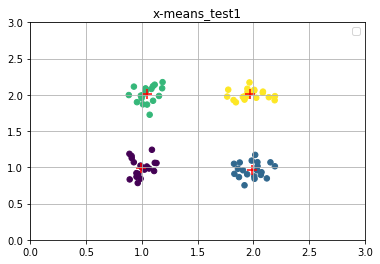

In [16]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    # データの準備
    x = np.array([np.random.normal(loc, 0.1, 20) for loc in np.repeat([1,2], 2)]).flatten() #ランダムな80個の数を生成
    y = np.array([np.random.normal(loc, 0.1, 20) for loc in np.tile([1,2], 2)]).flatten() #ランダムな80個の数を生成
        #np.repeat([1, 2], 2)の出力結果は1,1,2,2
        #np.tile([1, 2], 2)の出力結果は1,2,1,2
        #np.random.normal(平均, 標準偏差, 出力配列のサイズ)        
    
    # クラスタリングの実行
    x_means = XMeans(random_state = 1).fit(np.c_[x,y])  
    print(x_means.labels_)
    print(x_means.cluster_centers_)
    print(x_means.cluster_log_likelihoods_)
    print(x_means.cluster_sizes_)

    # 結果をプロット
    plt.rcParams["font.family"] = "Hiragino Kaku Gothic Pro"
    plt.scatter(x, y, c = x_means.labels_, s = 30)
    plt.scatter(x_means.cluster_centers_[:,0], x_means.cluster_centers_[:,1], c = "r", marker = "+", s = 100)
    plt.xlim(0, 3)
    plt.ylim(0, 3)
    plt.title("x-means_test1")
    plt.legend()
    plt.grid()
    plt.show()

## クラスタ数が多いパターン(クラスタ数=100)

No handles with labels found to put in legend.
findfont: Font family ['Hiragino Kaku Gothic Pro'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Hiragino Kaku Gothic Pro'] not found. Falling back to DejaVu Sans.


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
[[ 2.00022741  3.50631497]
 [ 6.00597206  1.01263096]
 [ 6.04527536  1.98210798]
 [ 7.00815969  3.04990966]
 [ 6.97162784  4.02608134]
 [ 4.0026246   7.0034486 ]
 [ 4.00363168  7.99671576]

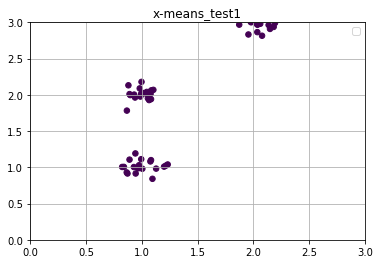

In [15]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    # データの準備
    x = np.array([np.random.normal(loc, 0.1, 20) for loc in np.repeat(range(1,11,1), 2)]).flatten() #ランダムな2000個の数を生成
    y = np.array([np.random.normal(loc, 0.1, 20) for loc in np.tile(range(1,11,1), 2)]).flatten() #ランダムな2000個の数を生成
        #np.repeat([1, 2], 2)の出力結果は1,1,2,2
        #np.tile([1, 2], 2)の出力結果は1,2,1,2
        #np.random.normal(平均, 標準偏差, 出力配列のサイズ)      
        #flattenは多次元配列を1次元に直すメソッド

        
    # クラスタリングの実行
    x_means = XMeans(random_state = 1).fit(np.c_[x,y])  
    print(x_means.labels_)
    print(x_means.cluster_centers_)
    print(x_means.cluster_log_likelihoods_)
    print(x_means.cluster_sizes_)

    # 結果をプロット
    plt.rcParams["font.family"] = "Hiragino Kaku Gothic Pro"
    plt.scatter(x, y, c = x_means.labels_, s = 30)
    plt.scatter(x_means.cluster_centers_[:,0], x_means.cluster_centers_[:,1], c = "r", marker = "+", s = 100)
    plt.xlim(0, 3)
    plt.ylim(0, 3)
    plt.title("x-means_test1")
    plt.legend()
    plt.grid()
    plt.show()

<ipython-input-14-4734bbe12621>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


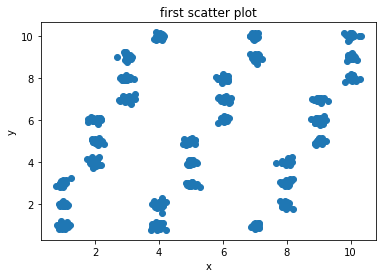

In [14]:
fig = plt.figure()

ax = fig.add_subplot(1,1,1)

ax.scatter(x,y)

ax.set_title('first scatter plot')
ax.set_xlabel('x')
ax.set_ylabel('y')

fig.show()

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])